In [1]:
from google.colab import files,drive

from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from torch.autograd import Variable
from string import punctuation
from sklearn.externals import joblib

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import collections
import nltk
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
"""
 Read Glove File take url of file return the two dictionaries ( word to index and word to vector in embedding )
 and one list of index to word  
 (glove file url) --> words_to_index, index_to_words, word_to_vec_map
 
 """

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [4]:
"""
Word Embeddings of words take dictionary of word to embedding and word to index
and return Embeddings Matrix [index,Embedding] 

"""

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1
    emb_matrix = np.zeros((vocab_len,300))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    return emb_matrix

In [5]:
"""
Call read_glove_vecs function and then call pretrained_embedding_layer to calc word Embedding of Words

"""

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/My Drive/Datasets/Word Embedding/glove.6B.300d.txt")
word_embedding=pretrained_embedding_layer(word_to_vec_map, word_to_index)


In [6]:
"""
Read Dataset (Data Frame)

"""

dftrain=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/train.tsv",sep="\t",header=None)
dfval=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/val.tsv",sep="\t",header=None)
dftest=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/test.tsv",sep="\t",header=None)

In [7]:
"""
list of columns's Name 

"""

cols=['index','ID','label','statement','subject','speaker',
      'speaker_job','state','party','barely_true',
      'false','half_true','mostly_true','pants_on_fire',
      'context','justification']

In [8]:
"""
Add list cols to Data Frame columns

"""

dftrain.columns=cols
dfval.columns=cols
dftest.columns=cols

In [9]:
"""
Make Datasets have only statement,subject,justification and label 
important Feauters to Training

"""

dftrain=dftrain.loc[:,['statement','subject','justification','label']]
dfval=dfval.loc[:,['statement','subject','justification','label']]
dftest=dftest.loc[:,['statement','subject','justification','label']]
dftrain=dftrain.append(dfval)
dftrain=dftrain.append(dftest)

In [10]:
"""
Drop NAN value and index column in Datasets 

"""

dftrain=dftrain.dropna(axis=0)

dftrain=dftrain.reset_index()

dftrain=dftrain.drop(['index'],axis=1)


In [11]:
"""  Show first two's row in dataset """

dftrain.head(2)

,statement,subject,justification,label
0,Says the Annies List political group supports ...,abortion,That's a premise that he fails to back up. Ann...,false
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments","Surovell said the decline of coal ""started whe...",half-true


In [12]:
"""
convert labels to 0,1 True or False  

"""
convertlabel = {
	'pants-fire': 0,
	'false': 0,
	'barely-true': 0,
	'half-true': 1,
	'mostly-true': 1,
	'true': 1
}

In [13]:
"""
Clean Text 

"""

def clean(text):
  text=text.lower()
  stp=set(stopwords.words("english"))
  placesp = re.compile('[/(){}\[\]\|@,;]')
  removech= re.compile('[^0-9a-z #+_]')
  st=WordNetLemmatizer()
  text=re.sub(placesp,' ',text)
  text=re.sub(removech,' ',text)
  text=text.split()
  text=[w for w in text if not w in stp]
  text=[st.lemmatize(w) for w in text]
  text=" ".join(text)
  text = text.translate(str.maketrans("", "", string.punctuation))
  return text

In [14]:
"""
Transfer sentence to indeces word in Embedding
take text and word to index dictionary 
return list of indeces word in Embedding

"""
def transfer_sent(text,word_to_index):
  text=text.split(' ')
  ret=[]
  for w in text:
    if w in word_to_index and w !="":
      ret.append(word_to_index[w])
  return ret

In [15]:
"""
Convert Labels dataset to 0,1 by Call convertlabel Function , 
sentence to indeces by call transfer_sent Function

"""

for i in range(dftrain.shape[0]):
  dftrain.loc[i,'label']=convertlabel[dftrain.loc[i,'label']]
  dftrain.loc[i,'statement']=transfer_sent(clean(dftrain.loc[i,'statement']),word_to_index)
  dftrain.loc[i,'subject']=transfer_sent(clean(dftrain.loc[i,'subject']),word_to_index)
  dftrain.loc[i,'justification']=transfer_sent(clean(dftrain.loc[i,'justification']),word_to_index)

In [16]:
""" Take Labels two make only Target dataset and drop it in orignal dataset """

dftrainy=dftrain['label']

dftrain=dftrain.drop(['label'],axis=1)

In [17]:
"""
calculate the Max Length in every column in Data Frame 
take Data Frame 
return Max lenght of columns

"""

def retmax(dftrain):

  stmax,sumax,jumax=0,0,0
  for i in range(dftrain.shape[0]):

    stmax=max(stmax,len(np.array(dftrain.loc[i,'statement'])))

    sumax=max(sumax,len(np.array(dftrain.loc[i,'subject'])))

    jumax=max(jumax,len(np.array(dftrain.loc[i,'justification'])))

  return stmax,sumax,jumax


In [18]:
"""
Convert Data Frame to Matrix 2D by Adding padding zeros to every columns that not have lenght not equal max
lenght.
take Data Frame list of Max Lenghts of Columns
return Matrix after convert

"""

def convert2D(Xs,max_lens):
   X_indices = np.zeros((Xs[0].shape[0], sum(max_lens)))
   pls=0

   for i in range(Xs[0].shape[0]):
     pls=0
     
     for j in range(0,len(Xs[0][i])):
       X_indices[i][j+pls]=Xs[0][i][j]
     pls=max_lens[0]

     for j in range(0,len(Xs[1][i])):
       X_indices[i][j+pls]=Xs[1][i][j]
     pls=max_lens[1]+max_lens[0]

     for j in range(0,len(Xs[2][i])):
       X_indices[i][j+pls]=Xs[2][i][j]
   return X_indices

In [19]:
def padding_text(text,ln):
  if len(text)<ln:
    text+=[0]*(ln-len(text))
  return text

In [20]:
"""
Calc Max Lengths in every Columns by call retmax Function ,
convert Data Frame to Matrix by convert2D Function

"""

stmax,sumax,jumax=retmax(dftrain)
Fulldata=np.array(convert2D([dftrain.statement,dftrain.subject,dftrain.justification],[410,30,1000]))


In [21]:
""" Split dataets to Training ,Validation and Testing Datasets """

dftrainy=list(dftrainy)
training,trainingy=Fulldata[:8885],dftrainy[:8885]
validation,validationy=Fulldata[8886:11425],dftrainy[8886:11425]
testing,testingy=Fulldata[11426:],dftrainy[11426:]

In [22]:
""" Convert every Datasets to Torch Datasets """

training=torch.from_numpy(training)
trainingy = torch.tensor(trainingy) 
train_tensor = torch.utils.data.TensorDataset(training, trainingy)

validation=torch.from_numpy(validation)
validationy = torch.tensor(validationy) 
valid_tensor = torch.utils.data.TensorDataset(validation, validationy)

testing=torch.from_numpy(testing)
testingy = torch.tensor(testingy) 
test_tensor = torch.utils.data.TensorDataset(testing, testingy)

In [23]:
""" Create DataLoader to Every Datasets """

train_loader=torch.utils.data.DataLoader(dataset=train_tensor,batch_size=32,shuffle=True, num_workers=0)
vali_loader=torch.utils.data.DataLoader(dataset=valid_tensor,batch_size=32,shuffle=True, num_workers=0)
test_loader=torch.utils.data.DataLoader(dataset=test_tensor,batch_size=32,shuffle=True, num_workers=0)


In [24]:
"""
Call read_glove_vecs function and then call pretrained_embedding_layer to calc word Embedding of Words

"""

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/My Drive/Datasets/Word Embedding/glove.6B.300d.txt")
word_embedding=pretrained_embedding_layer(word_to_vec_map, word_to_index)


In [25]:
""" Model to Training Data 

  Forward Function
Take length of Embedding and Dim of it and Create Embedding Layer by torch Framework
Create Neural Network Layer take 903 input and return 256 as output layer
then bass output to non-activation function layer then add dropout to output
bass output to Linear take 256 and return number of class 1 and then add sigmoid to output

  Conv Function 
Take inputs ( self, inputs layer[batch size of training inputs*Featuers] (32,1440) )

conv inputs layer from [32,1440] to [32,903]

first 300s number repersent the vector sentence(Statement) of Embedding

301 add Similarity of Statement Featuer (first [410] numbers of orignal input) and 
  Subject Featuer (second [30] numbers of orignal input)

from 302 to 602 add number repersent the vector sentence(Subject) of Embedding

602 add Similarity of Subject Featuer ([30] numbers of orignal input) and 
  Justification Featuer (second [1000] numbers of orignal input)

from 602 to 902 add number repersent the vector sentence(Justifaction) of Embedding

903 add Similarity of Justification Featuer ([100] numbers of orignal input) and 
  Statement Featuer (second [410] numbers of orignal input)

and return [32,903]

Then Pass output of Conv to Forward


"""

class NN(nn.Module):


  def __init__(self, vocab_size,batch_size, embedding_dim,lens,word_embedding,hidden_dim):

    super(NN, self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.batch_size=batch_size
    self.lens=lens
    self.embedding = nn.Embedding(vocab_size, embedding_dim)   
    self.embedding.weight.data.copy_(word_embedding)

    self.lstm = nn.LSTM(3*self.embedding_dim+3, self.hidden_dim, 2, dropout=0.7, batch_first=True)
    self.fc = nn.Linear(self.hidden_dim,1)
    self.dropout=nn.Dropout(0.7)
    self.sig = nn.Sigmoid()



  def forward(self, x,hidden):

    batch = x.size(0)

    x = self.conv(x)


    lstm_out, hidden = self.lstm(x, hidden)
    lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
    out = self.dropout(lstm_out)

    out=self.sig(self.fc(out))
    sig_out = out.view(batch, -1)
    sig_out = sig_out[:, -1]
    return sig_out, hidden

    
  def conv(self,x):
    
    bacth=len(x)
    ret=torch.zeros((bacth,3*self.embedding_dim+3)).cuda()
    st=torch.zeros(self.embedding_dim).cuda()
    su=torch.zeros(self.embedding_dim).cuda()
    ju=torch.zeros(self.embedding_dim).cuda()


    
    for i in range(bacth):
      
      st=self.embedding(x[i][0:self.lens[0]]).sum(dim=0)/(x[i][0:self.lens[0]]!=0).sum()
      su=self.embedding(x[i][self.lens[0]:self.lens[1]]).sum(dim=0)/(x[i][self.lens[0]:self.lens[1]]!=0).sum()
      ju=self.embedding(x[i][self.lens[1]:self.lens[2]]).sum(dim=0)/(x[i][self.lens[1]:self.lens[2]]!=0).sum()
      
      ret[i][:self.embedding_dim]=st
      ret[i][self.embedding_dim]=F.cosine_similarity(st,su,dim=0)

      ret[i][self.embedding_dim+1:2*self.embedding_dim+1]=su
      ret[i][self.embedding_dim*2+1]=F.cosine_similarity(su,ju,dim=0)

      ret[i][2*self.embedding_dim+2:3*self.embedding_dim+2]=ju
      
      ret[i][self.embedding_dim*3+2]=F.cosine_similarity(st,ju,dim=0)
    return ret.view(1,bacth,self.embedding_dim*3+3)


  def init_hidden(self):
    weight = next(self.parameters()).data
    hidden = (weight.new(2, 1, self.hidden_dim).zero_().cuda(),
                  weight.new(2, 1, self.hidden_dim).zero_().cuda())
    return hidden

In [26]:
"""
object from NN Model
and print it
"""
vocab_size = len(word_to_index)+1
embedding_dim = 300
net = NN(vocab_size,32, embedding_dim,[410,440,1440],torch.from_numpy(word_embedding),256)

In [27]:
"""
Learning rate 0.001
create Binary Cross Entropy Loss function
Create Adam optimizer to optimization parameters of NN ( Embedding , Linear Layers )

"""
lr=0.0001

net.cuda()
criterion = nn.BCELoss()

optimizer1 = torch.optim.Adam(net.lstm.parameters(), lr=lr)

optimizer2 = torch.optim.Adam(net.fc.parameters(), lr=lr)


In [28]:
""" 10 Number Epoch """

LtraininVis,LvalidVis=[],[]
LtrainAcc,LvalidAcc=[],[]

batch_size=32
epochs = 20
mnloss=np.Inf

net.train() 

for e in range(epochs):

  Taccuracy,Vaccuracy=[],[]
  losses=[]
  h = net.init_hidden()
  for inputs, labels in train_loader:

    inputs, labels = inputs.cuda(), labels.cuda()  

    h = tuple([each.data for each in h])

    net.zero_grad()
    
    output,h= net(inputs.long(),h)
    
    Taccuracy.append(((torch.round(output)==labels).sum()/float(len(labels))).item())

    loss = criterion(output.squeeze().float(), labels.float())



    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(net.parameters(), 5)
    optimizer1.step()
    optimizer2.step()
   


  with torch.no_grad():

    net.eval()
    val_losses = []
    
    val_h = net.init_hidden()

    for inputs, labels in vali_loader:

      inputs, labels = inputs.cuda(), labels.cuda()

      val_h = tuple([each.data for each in val_h])

      output,val_h= net(inputs.long(),val_h)

      Vaccuracy.append(((torch.round(output)==labels).sum()/float(len(labels))).item())

      val_loss = criterion(output.squeeze(), labels.float())

      val_losses.append(val_loss.item())

    net.train()

    LtraininVis.append(np.mean(losses))
    LvalidVis.append(np.mean(val_losses))

    LtrainAcc.append(np.mean(Taccuracy))
    LvalidAcc.append(np.mean(Vaccuracy))
    
    print("Epoch: {}/{}...".format(e+1, epochs),
          "Tarining Loss: {:.6f}...".format(np.mean(losses)),
          "Val Loss: {:.6f}".format(np.mean(val_losses)),
          "Val Accu:{:.6f}".format(np.mean(Vaccuracy)),
          "Training Accu:{:.6f}".format(np.mean(Taccuracy)))
    if mnloss>np.mean(val_losses):
      mnloss=np.mean(val_losses)
      print("Saving Model......")
      torch.save(net.state_dict(),'/content/drive/My Drive/model.pt')
      joblib.dump(net ,'/content/drive/My Drive/net.joblib')

Epoch: 1/20... Tarining Loss: 0.686512... Val Loss: 0.690016 Val Accu:0.538068 Training Accu:0.558657
Saving Model......
Epoch: 2/20... Tarining Loss: 0.684734... Val Loss: 0.689726 Val Accu:0.538814 Training Accu:0.563555
Saving Model......
Epoch: 3/20... Tarining Loss: 0.683110... Val Loss: 0.686322 Val Accu:0.539560 Training Accu:0.563833
Saving Model......
Epoch: 4/20... Tarining Loss: 0.680955... Val Loss: 0.682172 Val Accu:0.539169 Training Accu:0.563720
Saving Model......
Epoch: 5/20... Tarining Loss: 0.677395... Val Loss: 0.677340 Val Accu:0.549467 Training Accu:0.566520
Saving Model......
Epoch: 6/20... Tarining Loss: 0.671341... Val Loss: 0.672565 Val Accu:0.564205 Training Accu:0.573998
Saving Model......
Epoch: 7/20... Tarining Loss: 0.666448... Val Loss: 0.662928 Val Accu:0.613068 Training Accu:0.589901
Saving Model......
Epoch: 8/20... Tarining Loss: 0.662734... Val Loss: 0.662564 Val Accu:0.600036 Training Accu:0.597085
Saving Model......
Epoch: 9/20... Tarining Loss: 0.

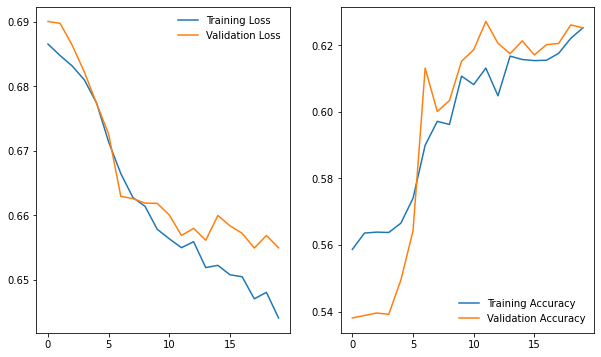

In [29]:
""" Visualiaztion Learning Curve """

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(LtraininVis,label='Training Loss')
ax1.plot(LvalidVis,label='Validation Loss')
ax1.legend(frameon=False)

ax2.plot(LtrainAcc,label='Training Accuracy')
ax2.plot(LvalidAcc,label='Validation Accuracy')
ax2.legend(frameon=False)


In [31]:
"""Testing Model"""
net.load_state_dict(torch.load('/content/drive/My Drive/model.pt'))
testloss=[]
testaccutacy=[]
net.eval()

val_h = net.init_hidden()

for inputs, labels in test_loader:

      inputs, labels = inputs.cuda(), labels.cuda()

      test_h = tuple([each.data for each in val_h])

      output,val_h= net(inputs.long(),val_h)

      testaccutacy.append(((torch.round(output)==labels).sum()/float(len(labels))).item())

      test_loss = criterion(output.squeeze(), labels.float())

      testloss.append(val_loss.item())


print("Testing Accuracy ",np.mean(testaccutacy))

Testing Accuracy  0.6223958328366279


In [32]:
statement="The decade that shattered trust in politics"
subject="politics"
justification='''It is totally normal for ministers and officials in high pressure jobs to have quarrels and tricky conversations.

Arguably, a bit of healthy tension can be a good thing for governments, to make sure that ideas are tested and policies properly thought through.

It is also normal from time to time for senior officials to move quietly to different government departments if a relationship breaks down with their political boss, or sometimes, for them to retire early if the situation has become impossible.

There is nothing remotely normal however about a top government official quitting their job, suing the government in the belief they were forced out, deciding to go public with the reasons, and accusing one of the most senior politicians in the country of not being straight with the truth.

But that is exactly what's happened. Sir Philip Rutnam has been one of the most senior civil servants for years, in charge at the Home Office for the last few.

His time there has not always been an unalloyed success - the Home Office, as one of the biggest and most complicated departments in the government, has struggled with various issues, most notably the Windrush scandal. The Home Office is often seen as a poisoned chalice given the nature of its job.'''

In [33]:
statement=padding_text(transfer_sent(clean(statement),word_to_index),410)
subject=padding_text(transfer_sent(clean(subject),word_to_index),30)
justification=padding_text(transfer_sent(clean(justification),word_to_index),1000)

once=torch.tensor([statement+subject+justification])

net.eval()
h=net.init_hidden()
pred,h=net(once.cuda(),h)
print("{:.1f}% of Truth.".format(pred.item()*100))


52.1% of Truth.
